To-do
* Currently all inputs are expected to be continuous. This may be favorable, but a user may and should be able to play with discrete variables.
* Instructions on how to properly sample $X$ and thus $f(X)$ should be supplied. (just take uniform or Sobol sequence) but this should atleast be explained
* An installation guide (with or without pytorch) needs to be provided
* A function exporting both the sensitivity as well as the uncertainty analysis in a sensible format should be outputted optionally.

In [2]:
# Importing the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sensitivity analysis toolkit
import pygpc

# Models (each of these models can function as universal surrogate models)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor                               # Default surrogate model.

# Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Misc
from sklearn.preprocessing import MinMaxScaler, StandardScaler # MinMaxScaler transforms to [0, 1], StandardScaler transforms to Z-scores
from scipy.integrate import solve_ivp                          # Redundant?
from scipy.interpolate import UnivariateSpline                 # Used to smoothen xgboost approximations of partial derivatives in the sensitvity analysis
from scipy.ndimage import gaussian_filter1d                    # Same as above
from scipy.stats import norm                                   # For computing a quasi-normal Sobol sequence

# Importing toy-data generators
from toymodels import (pendulum_angle, falling_velocity, 
                        simulate_ou_process, simulate_ou_process_analytic)

This notebook presents a framework that (mostly) automates sensitivity analysis and uncertainty analysis. In particular, we focus on uncertainty propagation, which looks at how uncertainty in the inputs of a model affects its outputs.

We treat models as black boxes, represented by a function $f$, that takes some input $X$ and produces an output $Y=f(X)$ The input $X$ can include many kinds of variables—for example: a person's age, an interest rate, or air resistance in a physics simulation.

In real-world situations, we often don't know the exact values of these input variables. Instead, we might only know that they fall within a certain range or distribution. This framework helps analyze how that uncertainty in the inputs affects the model's results.

# Uncertainty
As an example (shown below), imagine analyzing the speed of an object falling through the air. This speed depends on several factors: its initial speed ($v_0$), the air resistance ($k$), its mass $m$), and gravitational acceleration ($g$). In practice, none of these values are known exactly.

Instead, we might model them as uncertain values drawn from normal distributions. For instance:
$$(v_0, k, m, g) \sim Normal\left(\mu=(2, 5, 5, 9.81), \sigma=\left(\frac{1}{10}, \frac{1}{5}, \frac{1}{20}, \frac{1}{1000}\right)\right)$$
This means that each variable is centered around a typical value (the mean, $\mu$), but there's some spread or uncertainty (the standard deviation, $\sigma$) around it.

Given these uncertainties in the inputs, we ask: How do they influence the uncertainty in the output YY? And more specifically: How much does each input—and combinations of inputs—contribute to the overall uncertainty in $Y$?

# Tornado plot als optionele toevoeging

# Sensitivity
In addition to uncertainty analysis, it's also valuable to consider how the output $Y$ changes when a single input $X$ is altered. For example, what happens if we change the gravitational acceleration $g$? Understanding this can provide insights into how the model works and help ensure that it behaves as expected.

To quantify this, we can observe the change in the output when we increase one input, say $X_1$, while keeping the others constant:
$$f(X_1+1, \dots) - f(X_1, \dots)\approx \frac{df}{dX_1}(X)$$
This expression shows that by making such a change, we are approximating the derivative of the model, which represents the rate of change of the output with respect to that input. More precisely, we compute the gradient of the function:
$$\nabla f(X) = \left( \frac{\partial f}{\partial X_1},\ \frac{\partial f}{\partial X_2},\ \frac{\partial f}{\partial X_3},\ \frac{\partial f}{\partial X_4} \right)$$
The partial derivatives tell us how sensitive the output is to each individual input. By examining these partial derivatives, we can validate whether the model behaves as expected and also identify which inputs have the greatest influence on the output. This can guide future research, especially in determining which input variables need more precise estimation, particularly when their partial derivatives are large.

Provided an estimate or guess of an input parameter $\theta$, the values of $f$ are estimated for each dimension of $\theta$ where we take a single dimension $j$ and estimate $f(\theta - 0.2\cdot\theta_j)$ to $ f(\theta + 0.2\cdot\theta_j)$ With such plots, one can answer questions like "What is we nudge the input parameter by 10% or even 20%?" As $f$ is estimated by a surrogate model $\hat{f}$, which may or may not be a model that naturally results in "harsh" estimates in the sense of jumps, it is natural to smooth such $\hat{f}$ to obtain $\tilde{f}$. Smooth functions are differentiable and thus we can compute $\nabla \tilde{f}(\theta) \approx \nabla f(\theta)$. That will be the main ingredient for sensitivity analyses.

# Surrogate modelling
Sometimes, running the original model to perform uncertainty or sensitivity analysis can be too time-consuming, especially if the model is complex or computationally expensive. In such cases, we can use a surrogate model as a faster approximation of the original model.

A surrogate model is a simplified version of the original model that is computationally cheaper to evaluate. The user can provide a set of input-output pairs $X$ and $Y$ from their own model. Based on this data, a surrogate model can be built. Common types of surrogate models include well-known algorithms such as random forests, XGBoost, or other more custom models tailored to the specific problem.

# Computational tooling
The class SurrogateAnalysis combines all these ideas

# Showcase Problems
Currently, three "toy-models" are implemented.

### Falling object (simple formula)
The velocity of a falling object considering air resistance is given by:
$$v(t)=\frac{mg}{k}+(v_0-\frac{mg}{k})e^{-\frac{k}{m}t}$$
At time $t=8$, this formula calculates the velocity of the object after 8 seconds.

### Swinging pendulum (numerical solver)
The motion of a pendulum, typically modeled by the equation:
$$\frac{d^2\theta}{dt^2}+\frac{g}{L}\sin(\theta)=0$$
requires numerical methods to solve due to the nonlinearity of the sine term.

### Ornstein-Uhlenbeck (contains stochasticity)
The Ornstein-Uhlenbeck process is a stochastic differential equation used to model mean-reverting behavior with noise:
$$dX_t=-\theta X_tdt + \sigma dB_t$$
Where $B_t$ represents Wiener noise, and $\theta$ and $\sigma$ control the rate of mean reversion and volatility.

In [ ]:
class SurrogateAnalysis:
    """Leg eens uit wat deze ding doet"""

    def __init__(self, X, y, surrogate_model, model_init_kwargs=None, num=2**10): # add args for the surrogate_model.
        """
        X, y: training data
        surrogate_model_cls: the model class (e.g., RandomForestRegressor)
        model_init_kwargs: optional dict of init kwargs for surrogate model
        """
        self.input_X = X
        self.input_y = y

        self.generated_X = None
        self.generated_y = None

        if model_init_kwargs is None:
            model_init_kwargs = {}
        self.surrogate_model = surrogate_model(**model_init_kwargs)

        self.num = num
        self.dim = self.input_X.shape[1]
        self.problem = None
        self.type_of_analysis = None

        
    def fit_surrogate(self, tune_hyperparameters=False):
        """Fitting a surrogate modeling. It fits the model as given as input when creating the SurrogateAnalysis object"""
        if tune_hyperparameters:
            print("Hyperparameters to be implemented")

        self.surrogate_model.fit(self.input_X, self.input_y)

        self._assess_surrogate_quality()

    def _assess_surrogate_quality(self):
        """Evaluate the fit quality of the surrogate on training data."""
        y_pred = self.surrogate_model.predict(self.input_X)
        errors = y_pred - self.input_y

        mae = mean_absolute_error(self.input_y, y_pred)
        mse = mean_squared_error(self.input_y, y_pred)
        max_err = np.max(np.abs(errors))
        quantiles = np.percentile(errors, [10, 90])

        print("\n--- Surrogate Model Quality Assessment ---")
        print(f"Mean Absolute Error     : {mae:.4f}")
        print(f"Mean Squared Error      : {mse:.4f}")
        print(f"Max Absolute Error      : {max_err:.4f}")
        print(f"Error Quantiles (10%, 90%): ({quantiles[0]:.4f}, {quantiles[1]:.4f})")


    def predict(self, new_X=None):
        """Uses the fitted surrogate model"""

        if isinstance(new_X, str) and new_X == "Input":
            self.generated_y = self.surrogate_model.predict(self.input_X)

        elif isinstance(new_X, str) and new_X == "Generated":
            ## Check if self.generated_X even exists
            self.generated_y = self.surrogate_model.predict(self.generated_X)

        else:
            print("Custom input is expected.")
            self.generated_y = self.surrogate_model.predict(new_X)

        print(f"Prediction is made for a {self.type_of_analysis} analysis")

        return self.generated_y

    
    def plot_surrogate(self):
        """This plot implements a way to visualise the Saltelli indices"""

        # Requires a fitted surrogate model

        output_surrogate = self.predict("Input")
        plt.scatter(self.input_X[:,0], self.input_y, color="b", alpha=1)
        plt.scatter(self.input_X[:,0], output_surrogate, color="r", alpha=0.6)
        plt.title("Blue is the original input and output, red is the surrogate model")


    def generate_sobol_normals(self, mean_vector, sd_vector):
        """Generates new input values using Saltelli method. This requires powers of 2 as sample sizes. Note: 2**10 = 1024
        REMARK: still implement something clever for keeping certain fariables fixed."""

        print("Generating quasi-Monte Carlo gaussian samples")
             
        self.problem = {'num_vars': self.dim, 
                        'names': [f"x{k}" for k in range(1, self.dim+1)], 
                        'bounds': [[-1.0, 1.0] for _ in range(self.dim)]}

        # Sampling a Sobol sequence on the unit hypercube and using the inverse gaussian CDF to transform this to quasi-normal samples.
        hypercube_samples = pygpc.sobol_saltelli.saltelli_sampling(self.num, self.problem['num_vars'])
        hypercube_samples_transformed = norm.ppf(hypercube_samples)

        return mean_vector + sd_vector*hypercube_samples_transformed


    def write_output_uncertainty_analysis(output_location):
        pass

    def write_output_sensitivity_analysis(output_location):
        pass


    def perform_uncertainty_analysis(self, var_names, mean_vector, sd_vector, true_model=None, output_location=""):
        """Performs the sensivity analysis using pygpc"""

        generated_input_samples = self.generate_sobol_normals(mean_vector, sd_vector)

        if true_model: # If True, uses the original model
            self.model_used = "original"
            y_values = true_model(generated_input_samples).reshape(-1, 1)
        else:
            self.model_used = "surrogate"
            y_values = self.surrogate_model.predict(generated_input_samples).reshape(-1, 1)

        indices, var_combinations, _ = pygpc.sobol_saltelli.get_sobol_indices_saltelli(y_values, self.problem['num_vars'])

        if output_location:
            self.write_output_uncertainty_analysis(output_location)

        print(f"""The total variance of the output given the uncertainty in the input is {np.var(y_values):.3f}.
        Sobol Sensitivity Indices using the **{self.model_used}** model:\n""")
        
        for i, (idx_val, combo) in enumerate(zip(indices, var_combinations)):
            # idx_names = [self.problem['names'][j] for j in combo]
            idx_names = [names[j] for j in combo]
            names_str = " & ".join(idx_names)
            print(f"{i+1}. S_{'{' + names_str + '}'} = {idx_val[0]:.4f}")
        print("\n")


    def compute_sobol_indices(self):
        """Computes Sobol indices using quasi-normal samples."""
        quasi_normals = self.generate_sobol_normals()
        # Use the generated quasi-normal samples as input to your model (e.g., running the model)
        # Here we assume you have a function `model_output` that returns the output of the model.
        y_values = self.model_output(quasi_normals)  # Replace with actual model call

        # Now calculate Sobol indices using the output of the model
        indices, var_combinations, _ = pygpc.sobol_saltelli.get_sobol_indices_saltelli(y_values, self.problem['num_vars'])
        return indices


    def perform_sensitivity_analysis(self, name_vector, mean_vector, knots=200, smoothing_parameter=1.0, true_model=None, output_location=""):
        
        # Here we make a for-loop that computes the XGboost predictions for all axes.
        # SHould be for numeric columns only.

        X_template = np.tile(mean_vector, (knots, 1)).astype(float)

        # Corresponding columns of the arrays below make pairs.
        X_values = np.zeros_like(X_template)
        y_values = np.zeros(knots)
        y_values_smoothened = np.zeros(knots)
        y_values_derivative = np.zeros(knots)

        if true_model: # For validation purposes
            self.supplied_true_model = True
            y_values_smoothened_true = np.zeros(knots)
            y_values_derivative_true = np.zeros(knots)

        self.results = {}

        for i, name in enumerate(name_vector):

            X_array = X_template.copy()
            X_values[:, i] = np.linspace(mean_vector[i] * 0.8, mean_vector[i] * 1.2, knots)
            X_array[:, i] = X_values[:, i]
            y_vals = self.predict(X_array)

            # Here we smoothen it all.
            spline = UnivariateSpline(X_values[:, i], y_vals, s=smoothing_parameter)
            y_smooth = spline(X_values[:, i])
            y_derivative = spline.derivative()(X_values[:, i])

            self.results[name] = {
                'x': X_values[:, i],
                'y': y_vals,
                'y_smooth': y_smooth,
                'y_derivative': y_derivative,
                'mean': mean_vector[i]  # Add mean value here
            }

            # Compute true outcome and derivatives (only if a ground truth model is supplied)
            if true_model: 
                
                y_values_true = true_model(X_array)
                y_values_derivative_true = np.gradient(y_values_true, X_values[:, i])

                self.results[name].update({
                    'y_true': y_values_true,
                    'y_derivative_true': y_values_derivative_true
                    })

        
        if output_location:
            self.write_output_sensitivity_analysis(output_location)

    def plot_sensitivity_analysis(self):
        n_features = len(self.results)
        fig, axs = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))

        if n_features == 1:
            axs = [axs] 

        for i, (name, res) in enumerate(self.results.items()):
            # Plot predictions
            axs[i][0].plot(res['x'], res['y'], label='Original', alpha=0.3)
            axs[i][0].plot(res['x'], res['y_smooth'], label='Smooth', color='blue')
            axs[i][0].axvline(res['mean'], color='gray', linestyle='--', label='Mean', alpha=0.5)
            axs[i][0].set_title(f"Model values for varying {name}: $f(X \pm 0.2{name})$")

            if self.supplied_true_model:
                axs[i][0].plot(res['x'], res['y_true'], label='Original model', color='red', alpha=0.3)
                
            axs[i][0].legend()

            # Plot derivatives
            axs[i][1].plot(res['x'], res['y_derivative'], color='green')
            axs[i][1].axvline(res['mean'], color='gray', linestyle='--', label='Mean', alpha=0.5)
            axs[i][1].set_title(f"Derivative of model for {name}: $\partial_{name} f(X \pm 0.2{name})$")
            
            if self.supplied_true_model:
                axs[i][1].plot(res['x'], res['y_derivative_true'], label='Original model derivative', color='red', alpha=0.3)
                
            axs[i][1].legend()


        for ax in axs.flatten():
            ax.set_xlabel('Input Value')

        plt.tight_layout()
        plt.show()

We first apply the above class to perform uncertainty and sensitivity analysis to a falling object with air resistance. This follows the differential equation
$$\frac{dv(t)}{dt} = g - \frac{k}{m}v(t)$$
which is solved by 
$$v(t)=\frac{mg}{k}+(v_0-\frac{mg}{k})e^{-\frac{k}{m}t}$$
We now let the 4 parameters vary.

In [28]:
n_samples = 5000

X_fall = np.full(shape=(n_samples,4), fill_value=0.0)

X_fall[:, 0] = 9.81 + np.random.uniform(-2, 2, n_samples)  # g Unif(9.81-c, 9.81+c)
X_fall[:, 1] = np.random.uniform(1, 10, n_samples)         # m Unif(1, 10)
X_fall[:, 2] = 0.1 + 10*np.random.rand(n_samples)          # k Unif(0.1, 10.1)
X_fall[:, 3] = 5*np.random.rand(n_samples)                 # v0 ~ Unif(0, 5)

y_fall = falling_velocity(X_fall)

In [29]:
model_init_kwargs = {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}
surrogate_model_fall = SurrogateAnalysis(X_fall, y_fall, XGBRegressor, model_init_kwargs=model_init_kwargs, num=2**16)

# model_init_kwargs = {'n_estimators': 300, 'max_depth': 5}
# surrogate_model_fall = SurrogateAnalysis(X_fall, y_fall, RandomForestRegressor, model_init_kwargs=model_init_kwargs, num=2**14)

surrogate_model_fall.fit_surrogate()


--- Surrogate Model Quality Assessment ---
Mean Absolute Error     : 0.0025
Mean Squared Error      : 0.0000
Max Absolute Error      : 0.0254
Error Quantiles (10%, 90%): (-0.0041, 0.0039)


In [30]:
names = np.array(["g", "m", "k", "v0"])
means = np.array([9.81, 5, 5, 2])
sds = np.array([0.2, 0.1, 0.2, 0.5])

surrogate_model_fall.perform_uncertainty_analysis(var_names=names, mean_vector=means, sd_vector=sds)
surrogate_model_fall.perform_uncertainty_analysis(var_names=names, mean_vector=means, sd_vector=sds, true_model=falling_velocity)

Generating quasi-Monte Carlo gaussian samples
The total variance of the output given the uncertainty in the input is 0.180.
        Sobol Sensitivity Indices using the **surrogate** model:

1. S_{g} = 0.1268
2. S_{m} = 0.2152
3. S_{k} = 0.6154
4. S_{v0} = 0.0083
5. S_{g & m} = 0.0043
6. S_{g & k} = 0.0168
7. S_{g & v0} = 0.0017
8. S_{m & k} = 0.0092
9. S_{m & v0} = 0.0007
10. S_{k & v0} = 0.0012


Generating quasi-Monte Carlo gaussian samples
The total variance of the output given the uncertainty in the input is 0.234.
        Sobol Sensitivity Indices using the **original** model:

1. S_{g} = 0.1715
2. S_{m} = 0.1644
3. S_{k} = 0.6635
4. S_{v0} = 0.0000
5. S_{g & m} = 0.0002
6. S_{g & k} = 0.0003
7. S_{g & v0} = 0.0001
8. S_{m & k} = 0.0002
9. S_{m & v0} = -0.0001
10. S_{k & v0} = 0.0001




Below we perform a sensitivity analysis for the falling object. The formula was
$$v(t)=\frac{mg}{k}+(v_0-\frac{mg}{k})e^{-\frac{k}{m}t}$$
So the gradient is (also evaluated at $(m, g, k, v_0) = (5, 9.81, 5, 2)$) and $t=8$:

$$\nabla_{(m, g, k, v_0)} v(t) = \nabla v(X) = \left( \frac{\partial v}{\partial m},\ \frac{\partial v}{\partial g},\ \frac{\partial v}{\partial k},\ \frac{\partial v}{\partial v_0} \right)$$


In the experiment below, these (numerically approximated) gradients are validated (provided enough samples)

Custom input is expected.
Prediction is made for a None analysis
Custom input is expected.
Prediction is made for a None analysis
Custom input is expected.
Prediction is made for a None analysis
Custom input is expected.
Prediction is made for a None analysis


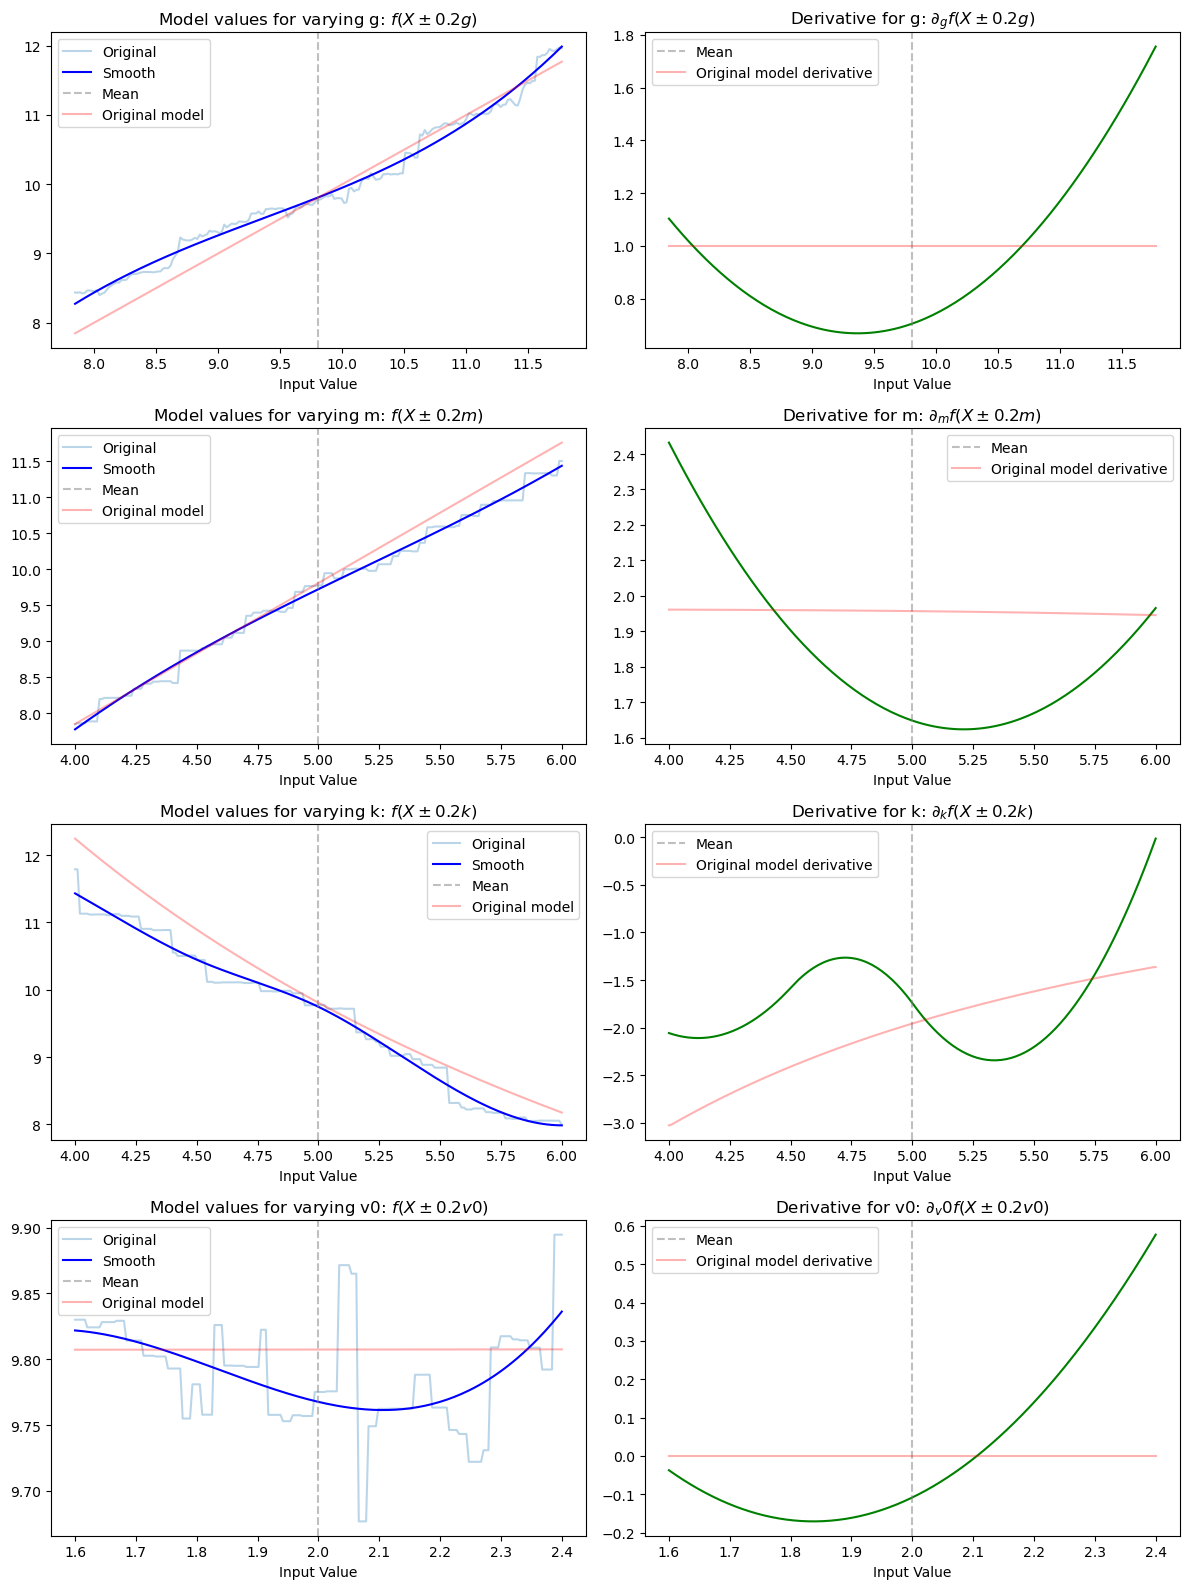

In [31]:
surrogate_model_fall.perform_sensitivity_analysis(names, means, smoothing_parameter=3, true_model=falling_velocity)
surrogate_model_fall.plot_sensitivity_analysis()

Now Ornstein Uhlenbeck

In [ ]:
n_samples = 1000
X_ou = np.random.uniform(low=0, high=1, size=(n_samples, 2))
y_ou = simulate_ou_process(X_ou)
y_ou_analytic = simulate_ou_process_analytic(X_ou)

plt.scatter(X_ou[:,0], y_ou)
plt.scatter(X_ou[:,0], y_ou_analytic, alpha=0.3)
plt.title("Means of Ornstein-Uhlenbeck processes at T=2")

In [ ]:
model_init_kwargs = {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
surrogate_model_ou = SurrogateAnalysis(X_ou, y_ou, XGBRegressor, model_init_kwargs=model_init_kwargs, num=2**14)

surrogate_model_ou.fit_surrogate()

In [ ]:
names = np.array(["theta", "v"])
means = np.array([0.5, 0.5])
sds = np.array([0.1, 0.1])

surrogate_model_ou.perform_uncertainty_analysis(mean_vector=means, sd_vector=sds)
surrogate_model_ou.perform_uncertainty_analysis(mean_vector=means, sd_vector=sds, true_model=simulate_ou_process_analytic)

In [ ]:
surrogate_model_ou.perform_sensitivity_analysis(names, means, smoothing_parameter=3, true_model=simulate_ou_process_analytic)
surrogate_model_ou.plot_sensitivity_analysis()

Next the swinging pendulum, where is it after two seconds of swinging?
The first (0) column of X is de length of the swing. The second column is the gravity constant and the third is the starting angle of the swing.

In [32]:
n_samples = 1000

X_pendulum = np.full(shape=(n_samples,3), fill_value=0.0)

X_pendulum[:, 0] = 2 + 2*np.random.rand(n_samples) # N(3, 0.5)
X_pendulum[:, 1] = 9.811 + np.random.uniform(-3, 3, n_samples)   # Unif(9.81-c, 9.81+c)
X_pendulum[:, 2] = 2*np.random.rand(n_samples)     # N(3, 1)

y_pendulum = pendulum_angle(X_pendulum, t_target=8)

In [33]:
surrogate_model_pendulum = SurrogateAnalysis(X_pendulum, y_pendulum, XGBRegressor, num=2**10)
surrogate_model_pendulum.fit_surrogate()


--- Surrogate Model Quality Assessment ---
Mean Absolute Error     : 0.0078
Mean Squared Error      : 0.0001
Max Absolute Error      : 0.0585
Error Quantiles (10%, 90%): (-0.0121, 0.0127)


In [36]:
names = np.array(["L", "g", "theta"])
means = np.array([3, 9.81, 1])
sds = np.array([0.2, 0.1, 0.2])
surrogate_model_pendulum.perform_uncertainty_analysis(var_names=names, mean_vector=means, sd_vector=sds)
surrogate_model_pendulum.perform_uncertainty_analysis(var_names=names, mean_vector=means, sd_vector=sds, true_model=pendulum_angle)

Generating quasi-Monte Carlo gaussian samples
The total variance of the output given the uncertainty in the input is 0.130.
        Sobol Sensitivity Indices using the **surrogate** model:

1. S_{L} = 0.8590
2. S_{g} = 0.0822
3. S_{theta} = 0.0282
4. S_{L & g} = -0.0129
5. S_{L & theta} = 0.0164
6. S_{g & theta} = -0.0041


Generating quasi-Monte Carlo gaussian samples
The total variance of the output given the uncertainty in the input is 0.174.
        Sobol Sensitivity Indices using the **original** model:

1. S_{L} = 0.9211
2. S_{g} = 0.0235
3. S_{theta} = 0.0166
4. S_{L & g} = -0.0080
5. S_{L & theta} = 0.0335
6. S_{g & theta} = -0.0008




In [ ]:
surrogate_model_pendulum.perform_sensitivity_analysis(names, means, true_model=pendulum_angle)
surrogate_model_pendulum.plot_sensitivity_analysis()

In [ ]:
X_elastic = np.random.uniform(low=0, high=1, size=(500, 2))
y_elastic = elastic_net_quadratic(X_elastic)

surrogate_model_elastic = SurrogateAnalysis(X_elastic, y_elastic, XGBRegressor, num=2**14)
surrogate_model_elastic.fit_surrogate()

names = np.array(["alpha", "ratio"])
means = np.array([0.5, 0.5])

surrogate_model_elastic.perform_sensitivity_analysis(names, means, true_model=elastic_net_quadratic)
surrogate_model_elastic.plot_sensitivity_analysis()